# Birdsong Temporal Sequence Chunk and Transform
### Transform to CQT and CQT with Spec Augment Masking

In [369]:
import glob
import os
import itertools

import numpy as np
import pandas as pd
import scipy.io.wavfile as wavfile
import librosa

import nlpaug
import nlpaug.augmenter.spectrogram as nas
import nlpaug.flow 
import nlpaug.flow as naf

In [370]:
os.getcwd()

'/home/pattyry/birds'

In [371]:
# os.chdir('../')
#os.chdir('./file-index')
#index_dir = os.getcwd()
os.getcwd()

'/home/pattyry/birds'

In [372]:
def pitch_shift(y, sr, n_semitones):
    return librosa.effects.pitch_shift(y, sr, n_steps=n_semitones)


def augment_pitch_shifts(birdsongs_df, semitones=[1, 2, -1, -2]):
    for idx, birdsong in birdsongs_df.iterrows():
        for semitone in semitones:
            augment_birdsong = pitch_shift(birdsong['audio_samples'], birdsong['rate'], semitone)
            filename = birdsong['filename'].split('.')[0] + f'_pitch_shift_{semitone}.wav'
            wavfile.write(f'pitch-shift/{filename}', birdsong['rate'], augment_birdsong)

In [373]:
def octave_shift(y, sr, n_octaves):
    return librosa.effects.pitch_shift(y, sr, n_steps=12*n_octaves)


def augment_octave_shifts(birdsongs_df, octaves=[1, 2, -1, -2]):
    for idx, birdsong in birdsongs_df.iterrows():
        for octave in octaves:
            augment_birdsong = octave_shift(birdsong['audio_samples'], birdsong['rate'], octave)
            filename = birdsong['filename'].split('.')[0] + f'_octave_shift_{octave}.wav'
            wavfile.write(f'augmented-audio/{filename}', birdsong['rate'], augment_birdsong)

In [374]:
def augment_mixing_signals(birdsongs_df, mode='linear'):
    if mode not in ['linear', 'cartesian-product']:
        raise ValueError('mode must be one of "linear" or "cartesian-product"')
    if mode == 'linear':
        for i in range(len(birdsongs_df)-1):
            max_audio = min(len(birdsongs_df.loc[i]['audio_samples']), len(birdsongs_df.loc[i+1]['audio_samples']))
            augment_birdsong = birdsongs_df.loc[i]['audio_samples'][:max_audio] + birdsongs_df.loc[i+1]['audio_samples'][:max_audio]
            first_birdsong = birdsongs_df.loc[i]['filename'].split('.')[0].split('_')[1]
            second_birdsong = birdsongs_df.loc[i+1]['filename'].split('.')[0].split('_')[1]
            filename = f'sierrabirdsong_{first_birdsong}_{second_birdsong}.wav'
            wavfile.write(f'mixed-audio/{filename}',  birdsongs_df.loc[i]['rate'], augment_birdsong)
    elif mode == 'cartesian-product':
        for (i, j) in itertools.product(range(len(birdsongs_df)), repeat=2):
            max_audio = min(len(birdsongs_df.loc[i]['audio_samples']), len(birdsongs_df.loc[j]['audio_samples']))
            augment_birdsong = birdsongs_df.loc[i]['audio_samples'][:max_audio] + birdsongs_df.loc[j]['audio_samples'][:max_audio]
            first_birdsong = birdsongs_df.loc[i]['filename'].split('.')[0].split('_')[1]
            second_birdsong = birdsongs_df.loc[j]['filename'].split('.')[0].split('_')[1]
            filename = f'sierrabirdsong_{first_birdsong}_{second_birdsong}.wav'
            wavfile.write(f'mixed-audio/{filename}',  birdsongs_df.loc[i]['rate'], augment_birdsong)

In [375]:
def time_shift(y, sr, speed):
    return librosa.effects.time_stretch(y, speed)


def augment_time_shifts(birdsongs_df, speeds=[2, 0.5, 5, 0.2]):
    for idx, birdsong in birdsongs_df.iterrows():
        for speed in speeds:
            augment_birdsong = time_shift(birdsong['audio_samples'], birdsong['rate'], speed)
            filename = birdsong['filename'].split('.')[0] + f'_time_shift_{speed}.wav'
            wavfile.write(f'time-shift-audio/{filename}', birdsong['rate'], augment_birdsong)

In [376]:
# %%writefile preprocessing.py 
import numpy as np
import pandas as pd
import librosa


def min_len(X):
    min_len = len(X[0])
    for row in X:
        min_len = min(len(row), min_len)
    return min_len


def shuffle_audio(audio_wav, permutation):
    audio_wav = np.array(audio_wav)
    shape = audio_wav.shape
    audio_wav = audio_wav.reshape(len(permutation), -1)
    audio_wav = audio_wav[permutation]
    audio_wav = audio_wav.reshape(shape)
    return audio_wav


def preprare_audio_shuffle_learn_data(X, shuffles):
    min_audio_file_len = min_len(X)
    X = [x[:min_audio_file_len] for x in X]
#     X = [librosa.cqt(x) for x in X]
    
    shuffled_data = []
    if shuffles == 'all_permutations':
        pass
    else:
        for x in X:
            for shuffle in shuffles:
                x_shuffle = shuffle_audio(x, shuffle)
                shuffled_data.append(x_shuffle)
                
    y = np.array([True for _ in range(len(X))] + [False for _ in range(len(shuffled_data))])
    X = np.vstack((X, shuffled_data))
    X = np.array(X)
    return X, y
    
    
def prepare_audio_shuffle_learn_cnn_model_data(X, shuffles):
    X, y = preprare_audio_shuffle_learn_data(X, shuffles)
    #X_train = np.einsum('ikj->ijk', X_train)
    
    # Add a dummy channel dimension to be processed in a CNN
    X = X.reshape(X.shape + (1,))
    
    return X, y


In [377]:
def augment_masked_spec(birdsongs, mask_freq_factor, mask_time_1, mask_time_2):

    flow = naf.Sequential([
        nas.FrequencyMaskingAug(mask_factor=mask_freq_factor), 
        nas.TimeMaskingAug(mask_factor=mask_time_1), 
        nas.TimeMaskingAug(mask_factor=mask_time_2)
    ])
    primary_input = []
    cqt_out = []
    for birdsong in birdsongs:
#         birdsong = np.asfortranarray(birdsong)
        constant_q = np.abs(librosa.cqt(birdsong, 
                                        sr=22000, 
                                        fmin=librosa.note_to_hz('C1'), 
                                        n_bins=70, 
                                        bins_per_octave=112
                                    )
                           )
        augmented_spectrogram = flow.augment(constant_q).flatten()
        constant_q = constant_q.flatten()
        primary_input.append(augmented_spectrogram)
        cqt_out.append(constant_q)
#     primary_input = np.array(primary_input).reshape(-1, caugmented_spectrogram_shape_0, augmented_spectrogram_shape_1, 1)
#     print(VisualSpectrogram.visual('Frequency Masking', augmented_spectrogram))
    
    
    return primary_input, cqt_out

In [378]:
os.chdir('./file-index')
os.getcwd()

'/home/pattyry/birds/file-index'

In [379]:
import os
os.listdir()

['filtered-test-file-list.csv',
 'train_raw_data.csv',
 'filtered-train-file-list.csv',
 'test_raw_data.csv']

In [380]:
good_birdsongs_df_test = pd.read_csv('filtered-test-file-list.csv',header=None)
good_birdsongs_df_test.columns = ["filename"]
print(good_birdsongs_df_test.shape)
good_birdsongs_df_test.head(2)

(489, 1)


,filename
0,STC_0003.wav
1,STC_0005.wav


In [381]:
good_birdsongs_df_train = pd.read_csv('filtered-train-file-list.csv')
good_birdsongs_df_train = good_birdsongs_df_train.rename(columns={'birdsong_path': 'filename'})
good_birdsongs_df_train = good_birdsongs_df_train[['filename']]
print(good_birdsongs_df_train.shape)
good_birdsongs_df_train.head(2)


(763, 1)


,filename
0,sierrabirdsong_1.wav
1,sierrabirdsong_100.wav


In [382]:
os.chdir('/home/pattyry/birds/')
os.getcwd()

'/home/pattyry/birds'

In [383]:
birdsongs_train = []
rates = []

for filename in good_birdsongs_df_train['filename']:
    try:
        rate, birdsong = wavfile.read(f'resampled-train/{filename}')
        rates.append(rate)
        birdsongs_train.append(birdsong)
    except Exception as e:
        pass
    
good_birdsongs_df_train['audio_samples'] = birdsongs_train
good_birdsongs_df_train['rate'] = rates
good_birdsongs_df_train = good_birdsongs_df_train.sort_values('filename')
good_birdsongs_df_train.head()

,filename,audio_samples,rate
0,sierrabirdsong_1.wav,"[-0.0021551282, -0.0031709422, -0.0026361407, ...",22000
1,sierrabirdsong_100.wav,"[-0.001998026, -0.002881984, -0.0029002875, -0...",22000
2,sierrabirdsong_1000.wav,"[-0.00044918252, -0.00047377538, -0.0002746099...",22000
3,sierrabirdsong_1001.wav,"[-0.0014799404, -0.002844032, -0.003620765, -0...",22000
4,sierrabirdsong_1002.wav,"[-0.0007815379, -0.0012114772, -0.0011790622, ...",22000


In [384]:
birdsongs_test = []
rates = []
birdsong = []

for filename in good_birdsongs_df_test['filename']:
    try:
        rate, birdsong = wavfile.read(f'resampled-test/{filename}')
        rates.append(rate)
        birdsongs_test.append(birdsong)
    except Exception as e:
        pass
    
good_birdsongs_df_test['audio_samples'] = birdsongs_test
good_birdsongs_df_test['rate'] = rates
good_birdsongs_df_test = good_birdsongs_df_test.sort_values('filename')
good_birdsongs_df_test.head()

,filename,audio_samples,rate
0,STC_0003.wav,"[-0.0012736305, -0.0013998335, -0.00045392304,...",22000
1,STC_0005.wav,"[-0.0026490837, -0.004135022, -0.0040645003, -...",22000
2,STC_0006.wav,"[-0.0028597459, -0.0043404493, -0.003907238, -...",22000
3,STC_0007.wav,"[-0.00064887875, -0.0011912468, -0.0012977467,...",22000
4,STC_0008.wav,"[-0.0024054458, -0.0040544816, -0.0045157527, ...",22000


In [385]:
import IPython
IPython.display.Audio(data=good_birdsongs_df_train['audio_samples'][0], rate=rate)

In [386]:
import IPython
IPython.display.Audio(data=good_birdsongs_df_test['audio_samples'][0], rate=rate)

In [387]:
good_birdsongs_df_train['audio_samples'][0]

array([-0.00215513, -0.00317094, -0.00263614, ..., -0.00286914,
       -0.00180281, -0.00084945], dtype=float32)

In [388]:
len(good_birdsongs_df_train['audio_samples'][0])

231000

In [389]:
min_len_birdsong_train = min_len(good_birdsongs_df_train['audio_samples'])
print(min_len_birdsong_train)
min_len_birdsong_test = min_len(good_birdsongs_df_test['audio_samples'])
print(min_len_birdsong_test)

228800
228800


In [390]:
good_birdsongs_df_train['audio_samples'] = good_birdsongs_df_train['audio_samples'].apply(lambda x: x[:min_len_birdsong_train])
good_birdsongs_df_test['audio_samples'] = good_birdsongs_df_test['audio_samples'].apply(lambda x: x[:min_len_birdsong_test])

In [391]:
import IPython
IPython.display.Audio(data=good_birdsongs_df_train['audio_samples'][0], rate=rate)

### Split ten second sample into 4 equal lengthed sequencies.

In [392]:
def split_audio_samples(audio_samples, n_sequences=4):
    sequences = [[] for _ in range(n_sequences)]
    for audio_sample in audio_samples:
        split_audio_sample = np.split(audio_sample, n_sequences)
        for i in range(len(sequences)):
            sequences[i].append(split_audio_sample[i])
    return sequences

In [393]:


split_birdsong_sequences_train = split_audio_samples(good_birdsongs_df_train['audio_samples'])
split_birdsong_sequences_test = split_audio_samples(good_birdsongs_df_test['audio_samples'])

In [394]:
# shuffles = [np.array([0, 1, 3, 2]), np.array([1, 0, 2, 3]), np.array([3, 0, 1, 2])]
# birdsongs, target = preprare_audio_shuffle_learn_data(good_birdsongs_df['audio_samples'], shuffles)
# spec_aug_birdsongs = augment_masked_spec(birdsongs, 30, 10, 20)
# cqt_aug_birdsongs = [np.abs(librosa.cqt(aug_birdsong)) for aug_birdsong in aug_birdsongs]

In [395]:
print(split_birdsong_sequences_train[0][3].shape)
print(split_birdsong_sequences_test[0][3].shape)


(57200,)
(57200,)


### Spec Augment Split Bird Sequences

In [396]:
aug_sequences_train = []
cqt_sequences_train = []
for split_birdsong_sequence_train in split_birdsong_sequences_train:
    augment_split_birdsongs_train, original_cqt_train = augment_masked_spec(split_birdsong_sequence_train, 30, 10, 20)
    aug_sequences_train.append(augment_split_birdsongs_train)
    cqt_sequences_train.append(original_cqt_train)

In [ ]:
aug_sequences_test = []
cqt_sequences_test = []
for split_birdsong_sequence_test in split_birdsong_sequences_test:
    augment_split_birdsongs_test, original_cqt_test = augment_masked_spec(split_birdsong_sequence_test, 30, 10, 20)
    aug_sequences_test.append(augment_split_birdsongs_test)
    cqt_sequences_test.append(original_cqt_test)

In [78]:
a_train = np.array(aug_sequences_train[0])
np.savetxt(f'./spec-aug-sequences_train/a_train.csv', a_train, delimiter=',', fmt='%s',header='')
b_train = np.array(aug_sequences_train[1])
np.savetxt(f'./spec-aug-sequences_train/b_train.csv', b_train, delimiter=',', fmt='%s',header='') 
c_train = np.array(aug_sequences_train[2])
np.savetxt(f'./spec-aug-sequences_train/c_train.csv', c_train, delimiter=',', fmt='%s',header='') 
d_train = np.array(aug_sequences_train[3])
np.savetxt(f'./spec-aug-sequences_train/d_train.csv', d_train, delimiter=',', fmt='%s',header='')
labels_train = good_birdsongs_df_train['filename']
labels_train.to_csv(f'./spec-aug-sequences_train/labels_train.csv', header='')

a_test = np.array(aug_sequences_test[0])
np.savetxt(f'./spec-aug-sequences_test/a_test.csv', a_test, delimiter=',', fmt='%s',header='')
b_test = np.array(aug_sequences_test[1])
np.savetxt(f'./spec-aug-sequences_test/b_test.csv', b_test, delimiter=',', fmt='%s') 
c_test = np.array(aug_sequences_test[2])
np.savetxt(f'./spec-aug-sequences_test/c_test.csv', c_test, delimiter=',', fmt='%s') 
d_test = np.array(aug_sequences_test[3])
np.savetxt(f'./spec-aug-sequences_test/d_test.csv', d_test, delimiter=',', fmt='%s')
labels_test = good_birdsongs_df_test['filename']
labels_test.to_csv(f'./spec-aug-sequences_test/labels_test.csv', header='')


In [143]:
a_train_cqt = np.array(cqt_sequences_train[0])
np.savetxt(f'./cqt-sequences_train/a_train_cqt.csv', a_train_cqt, delimiter=',', fmt='%s',header='')
b_train_cqt = np.array(cqt_sequences_train[1])
np.savetxt(f'./cqt-sequences_train/b_train_cqt.csv', b_train_cqt, delimiter=',', fmt='%s',header='') 
c_train_cqt = np.array(cqt_sequences_train[2])
np.savetxt(f'./cqt-sequences_train/c_train_cqt.csv', c_train_cqt, delimiter=',', fmt='%s',header='') 
d_train_cqt = np.array(cqt_sequences_train[3])
np.savetxt(f'./cqt-sequences_train/d_train_cqt.csv', d_train_cqt, delimiter=',', fmt='%s',header='')
labels_train = good_birdsongs_df_train['filename']
labels_train.to_csv(f'./cqt-sequences_train/labels_train_cqt.csv', header='')


a_test_cqt = np.array(cqt_sequences_test[0])
np.savetxt(f'./cqt-sequences_test/a_test_cqt.csv', a_test_cqt, delimiter=',', fmt='%s',header='')
b_test_cqt = np.array(cqt_sequences_test[1])
np.savetxt(f'./cqt-sequences_test/b_test_cqt.csv', b_test_cqt, delimiter=',', fmt='%s',header='') 
c_test_cqt = np.array(cqt_sequences_test[2])
np.savetxt(f'./cqt-sequences_test/c_test_cqt.csv', c_test_cqt, delimiter=',', fmt='%s',header='') 
d_test_cqt = np.array(cqt_sequences_test[3])
np.savetxt(f'./cqt-sequences_test/d_test_cqt.csv', d_test_cqt, delimiter=',', fmt='%s',header='')
labels_test = good_birdsongs_df_test['filename']
labels_test.to_csv(f'./cqt-sequences_test/labels_test_cqt.csv', header='')

In [89]:
# a = augment_masked_spec([birdsongs[0][0*len(birdsongs[0])//4:1*len(birdsongs[0])//4]], 30, 10, 20)
# b = augment_masked_spec([birdsongs[0][1*len(birdsongs[0])//4:2*len(birdsongs[0])//4]], 30, 10, 20)
# c = augment_masked_spec([birdsongs[0][2*len(birdsongs[0])//4:3*len(birdsongs[0])//4]], 30, 10, 20)
# d = augment_masked_spec([birdsongs[0][3*len(birdsongs[0])//4:4*len(birdsongs[0])//4]], 30, 10, 20)
# spec_aug = np.concatenate((a, b, c, d), axis=2)


## Pitch Shift

In [92]:
import argparse
import glob
import os
import pickle

import numpy as np
import pandas as pd
import librosa


In [93]:
def pitch_shift_augment(audio_samples, sr, semitones=[1, 2, -1, -2]):
    aug_audio_sample_groups = {semitone: [] for semitone in semitones}
    for audio_sample in audio_samples:
        for semitone in semitones:
            aug_audio_sample = librosa.effects.pitch_shift(audio_sample, sr, n_steps=semitone)
            aug_audio_sample_groups[semitone].append(aug_audio_sample)
    return aug_audio_sample_groups

In [99]:
print(good_birdsongs_df_train.shape)
print(good_birdsongs_df_test.shape)
good_birdsongs_df_train.head(2)


(763, 3)
(489, 3)


,filename,audio_samples,rate
0,sierrabirdsong_1.wav,"[-0.0021551282, -0.0031709422, -0.0026361407, ...",22000
1,sierrabirdsong_100.wav,"[-0.001998026, -0.002881984, -0.0029002875, -0...",22000


In [100]:
pitch_shifted_train = pitch_shift_augment(good_birdsongs_df_train['audio_samples'], 22000)

In [105]:
def combine_dict_of_lists_to_list(audio_sample_groups):
    audio_samples = []
    for _, audio_sample_group in audio_sample_groups.items():
        audio_samples.append(audio_sample_group)
    audio_samples = np.concatenate(audio_samples, axis=0)
    return audio_samples

In [106]:
pitch_shifted_train = combine_dict_of_lists_to_list(pitch_shifted_train)

In [108]:
len(pitch_shifted_train)
pitch_shifted_train.shape

(3052, 228800)

In [115]:
print(pitch_shifted_train.shape)
print(pitch_shifted_train[3000,:])

(3052, 228800)
[-0.00091696 -0.00138238 -0.00129853 ...  0.          0.
  0.        ]


In [116]:
pitch_shifted_test = pitch_shift_augment(good_birdsongs_df_test['audio_samples'], 22000)

In [117]:
pitch_shifted_test = combine_dict_of_lists_to_list(pitch_shifted_test)

In [120]:
print(pitch_shifted_test.shape)

(1956, 228800)


In [122]:
os.getcwd()

'/home/pattyry/birds'

#### Save pitch shifted sequences

In [123]:
pitch_shifted_train = np.array(pitch_shifted_train)
np.savetxt(f'./pitch-shifted_train/pitch_shifted_train.csv', pitch_shifted_train, delimiter=',', fmt='%s',header='')

In [124]:
os.getcwd()

'/home/pattyry/birds'

In [125]:
pitch_shifted_test = np.array(pitch_shifted_test)
np.savetxt(f'./pitch-shifted_test/pitch_shifted_test.csv', pitch_shifted_test, delimiter=',', fmt='%s',header='')

In [126]:
### Split pitch shifted samples

In [131]:
pitch_shifted_train.shape

(3052, 228800)

In [132]:
def split_audio_samples(audio_samples, n_sequences=4):
    sequences = [[] for _ in range(n_sequences)]
    for audio_sample in audio_samples:
        split_audio_sample = np.split(audio_sample, n_sequences)
        for i in range(len(sequences)):
            sequences[i].append(split_audio_sample[i])
    return sequences

In [133]:
pitch_shifted_sequences_train = split_audio_samples(pitch_shifted_train)

In [134]:
pitch_shifted_sequences_test = split_audio_samples(pitch_shifted_test)

In [137]:
print(pitch_shifted_sequences_train[0][3].shape)
print(pitch_shifted_sequences_test[0][3].shape)

(57200,)
(57200,)


In [152]:
aug_pitch_sequences_train = []
cqt_pitch_sequences_train = []

for split_birdsong_sequence_train in pitch_shifted_sequences_train:
    augment_split_pitch_train, original_split_pitch_cqt_train = augment_masked_spec(split_birdsong_sequence_train, 30, 10, 20)
    aug_pitch_sequences_train.append(augment_split_pitch_train)
    cqt_pitch_sequences_train.append(original_split_pitch_cqt_train)

In [146]:
aug_pitch_sequences_test = []
cqt_pitch_sequences_test = []

for split_birdsong_sequence_test in pitch_shifted_sequences_test:
    augment_split_pitch_test, original_split_pitch_cqt_test = augment_masked_spec(split_birdsong_sequence_test, 30, 10, 20)
    aug_pitch_sequences_test.append(augment_split_pitch_test)
    cqt_pitch_sequences_test.append(original_split_pitch_cqt_test)

In [150]:
len(cqt_pitch_sequences_test)

4

In [153]:
a_train = np.array(cqt_pitch_sequences_train[0])
np.savetxt(f'./pitch-shifted_train/a_train_pitch.csv', a_train, delimiter=',', fmt='%s',header='')
b_train = np.array(cqt_pitch_sequences_train[1])
np.savetxt(f'./pitch-shifted_train/b_train_pitch.csv', b_train, delimiter=',', fmt='%s',header='') 
c_train = np.array(cqt_pitch_sequences_train[2])
np.savetxt(f'./pitch-shifted_train/c_train_pitch.csv', c_train, delimiter=',', fmt='%s',header='') 
d_train = np.array(cqt_pitch_sequences_train[3])
np.savetxt(f'./pitch-shifted_train/d_train_pitch.csv', d_train, delimiter=',', fmt='%s',header='')



In [157]:
d_train.shape

(3052, 7840)

In [151]:
a_test = np.array(cqt_pitch_sequences_test[0])
np.savetxt(f'./pitch-shifted_test/a_test_pitch.csv', a_test, delimiter=',', fmt='%s',header='')
b_test = np.array(cqt_pitch_sequences_test[1])
np.savetxt(f'./pitch-shifted_test/b_test_pitch.csv', b_test, delimiter=',', fmt='%s',header='') 
c_test = np.array(cqt_pitch_sequences_test[2])
np.savetxt(f'./pitch-shifted_test/c_test_pitch.csv', c_test, delimiter=',', fmt='%s',header='') 
d_test = np.array(cqt_pitch_sequences_test[3])
np.savetxt(f'./pitch-shifted_test/d_test_pitch.csv', d_test, delimiter=',', fmt='%s',header='')



In [ ]:
labels_train = good_birdsongs_df_train['filename']
labels_train.to_csv(f'./spec-aug-sequences_train/labels_train.csv', header='')

labels_train = good_birdsongs_df_train['filename']
labels_train.to_csv(f'./cqt-sequences_train/labels_train_cqt.csv', header='')

In [246]:
good_birdsongs_df_train.head(2)

os.chdir(birds_home)
os.getcwd()

In [355]:
def standardize_audio_duration(audio_samples, sr, duration=None):
    """Standardize the length of all audio samples to the length of the shortest sample

    Parameters
    ----------
    audio_samples : list
    duration : float (optional)
        Number of seconds to standardize the audio length to.
        If no value provided the length of the shortest audio clip will be chosen.

    Returns
    -------
    standardized_audio_samples : list
    """
    if duration:
        audio_length = int(sr * duration)
        standardized_audio_samples = [librosa.util.fix_length(sample, audio_length) 
            for sample in audio_samples]
        # try:
        #     standardized_audio_samples = [audio_sample[:audio_length] for audio_sample in audio_samples]
        # except IndexError as e:
        #     print('Audio Sample was shorter than the desired "audio_length"')
    else:
        audio_length = len(audio_samples[0]) 
        for audio_sample in audio_samples:
            audio_length = min(len(audio_sample), audio_length)
        standardized_audio_samples = [audio_sample[:audio_length] for audio_sample in audio_samples]
    return standardized_audio_samples



def time_stretch_augment(audio_samples, sr, rates=[0.81, 0.93, 1.07, 1.23], duration=10.4):
    aug_audio_sample_groups = {rate: [] for rate in rates}
    for audio_sample in audio_samples:
        for rate in rates:
            
            aug_audio_sample = librosa.effects.time_stretch(audio_sample[1], rate)
            aug_audio_sample_groups[rate].append(aug_audio_sample)
    for rate in aug_audio_sample_groups:
        aug_audio_sample_groups[rate] = standardize_audio_duration(
            aug_audio_sample_groups[rate], sr, duration=duration)
    return aug_audio_sample_groups


In [356]:
birds_home = os.path.join('/home/pattyry/birds/')
time_stretch = os.path.join(birds_home + 'time-stretch-train')
os.chdir(birds_home)
os.getcwd()

'/home/pattyry/birds'

In [357]:
good_birdsongs_df_train = np.asarray(good_birdsongs_df_train)

In [358]:
time_stretch_train = time_stretch_augment(good_birdsongs_df_train, 22000)

In [359]:
def combine_dict_of_lists_to_list(audio_sample_groups):
    audio_samples = []
    for _, audio_sample_group in audio_sample_groups.items():
        audio_samples.append(audio_sample_group)
    audio_samples = np.concatenate(audio_samples, axis=0)
    return audio_samples

time_stretch_train = combine_dict_of_lists_to_list(time_stretch_train)

In [360]:
time_stretch_train = np.array(time_stretch_train)
time_stretch_train.shape

(3052, 228800)

In [361]:
time_stretched_sequences_train = split_audio_samples(time_stretch_train)

In [362]:
time_stretched_sequences_train[0][3].shape

(57200,)

In [364]:
time_stretched_sequences_train[0][4]

array([-0.00077414, -0.00121664, -0.0011733 , ..., -0.00084247,
       -0.00067075, -0.00089767], dtype=float32)

In [366]:
aug_stretch_sequences_train = []
cqt_stretch_sequences_train = []

for split_birdsong_sequence_train in time_stretched_sequences_train:
    augment_split_stretch_train, original_split_stretch_cqt_train = augment_masked_spec(split_birdsong_sequence_train, 30, 10, 20)
    aug_stretch_sequences_train.append(augment_split_stretch_train)
    cqt_stretch_sequences_train.append(original_split_stretch_cqt_train)

In [367]:
cqt_stretch_sequences_train[0][3].shape

(7840,)

In [368]:
a_stretch_train = np.array(cqt_stretch_sequences_train[0])
np.savetxt(f'./time-stretch-train/a_stretch_train.csv', a_stretch_train, delimiter=',', fmt='%s',header='')
b_stretch_train = np.array(cqt_stretch_sequences_train[1])
np.savetxt(f'./time-stretch-train/b_stretch_train.csv', b_stretch_train, delimiter=',', fmt='%s',header='') 
c_stretch_train = np.array(cqt_stretch_sequences_train[2])
np.savetxt(f'./time-stretch-train/c_stretch_train.csv', c_stretch_train, delimiter=',', fmt='%s',header='') 
d_stretch_train = np.array(cqt_stretch_sequences_train[3])
np.savetxt(f'./time-stretch-train/d_stretch_train.csv', d_stretch_train, delimiter=',', fmt='%s',header='')

In [82]:
num_timesteps = 70
num_features = 112
sr = 22000
C1 = a_train_cqt[0]
C1.shape

(7840,)

In [83]:
C2 = b_train_cqt[0]
print(C2.shape)
C3 = c_train_cqt[0]
print(C3.shape)
C4 = d_train_cqt[0]
print(C4.shape)

(7840,)
(7840,)
(7840,)


In [84]:
C1 = np.array(C1).reshape(num_timesteps,num_features)
C2 = np.array(C2).reshape(num_timesteps,num_features)
C3 = np.array(C3).reshape(num_timesteps,num_features)
C4 = np.array(C4).reshape(num_timesteps,num_features)
C1.shape

(70, 112)

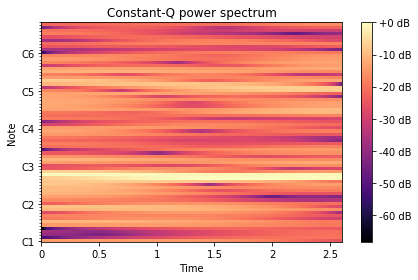

In [85]:
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(C1, ref=np.max),
                         sr=22000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()
plt.show()

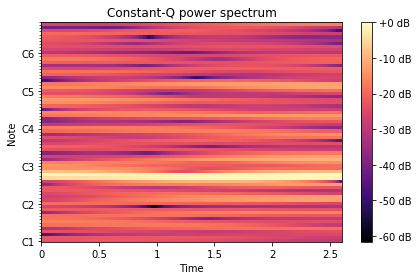

In [86]:
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(C2, ref=np.max),
                         sr=22000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()
plt.show()

In [88]:
# import matplotlib.pyplot as plt
# librosa.display.specshow(librosa.amplitude_to_db(spec_aug, ref=np.max),
#                          sr=22000, x_axis='time', y_axis='cqt_note')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Constant-Q power spectrum')
# plt.tight_layout()
# plt.show()